In [1]:
import arviz as az
import io
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pathlib import Path
import pymc as pm
import pytensor.tensor as pt
import requests
import statsmodels.api as sm
import warnings
import xarray as xr

#seed = sum(map(ord, "PyMC LABS - BVAR"))
#rng = np.random.default_rng(seed=seed)

warnings.filterwarnings(
    "ignore",
    category=UserWarning,
    module="openpyxl.worksheet._reader",
)

In [2]:
def companion_eigs(A_draw):
    """
    A_draw: (p, K, K) with VAR form y_t = sum_{l=1}^p A_l y_{t-l} + ...
    Returns eigenvalues of the companion matrix.
    """
    p, K, _ = A_draw.shape
    C = np.zeros((K * p, K * p))
    C[:K, :K * p] = np.hstack([A_draw[l] for l in range(p)])
    if p > 1:
        C[K:, :-K] = np.eye(K * (p - 1))
    return np.linalg.eigvals(C)

def ar_impulse_path(phi, H, shock0=1.0):
    """
    AR(p): x_t = sum_{l=1..p} phi[l-1]*x_{t-l} + u_t
    with u_0 = shock0, u_{t>0}=0, x_{t<0}=0
    Returns x[0..H].
    """
    p = len(phi)
    x = np.zeros(H + 1)
    u = np.zeros(H + 1)
    u[0] = shock0
    for t in range(H + 1):
        ar = 0.0
        for L in range(1, p + 1):
            if t - L >= 0:
                ar += phi[L - 1] * x[t - L]
        x[t] = ar + u[t]
    return x

def varx_irf(A_draw, B_draw, x_path, H):
    """
    VARX:
      y_t = sum_{l=1..p} A_l y_{t-l} + sum_{m=0..p} B_m x_{t-m}
    where:
      A_draw: (p, K, K)
      B_draw: (p+1, K)  with B_draw[0] = contemporaneous x_t coefficient
      x_path: (H+1,)
    Returns y[0..H, K] in the same units as A/B (typically standardized units).
    """
    p, K, _ = A_draw.shape
    assert B_draw.shape[0] == p + 1, "B_draw must have shape (p+1, K) for m=0..p"

    y = np.zeros((H + 1, K))

    for t in range(H + 1):
        # endogenous lags
        for L in range(1, p + 1):
            if t - L >= 0:
                y[t] += A_draw[L - 1] @ y[t - L]

        # exog contemporaneous
        y[t] += B_draw[0] * x_path[t]

        # exog lags
        for L in range(1, p + 1):
            if t - L >= 0:
                y[t] += B_draw[L] * x_path[t - L]

    return y

In [3]:
data_path = Path(Path.cwd().parent / "data processed" / "ads_dataset_extended.csv")
print("Processed ADS dataset")
print("Full file path: ",data_path)
print("File exists: ",data_path.exists())

Processed ADS dataset
Full file path:  /Users/awalters/escp_phd/govt_spending/data processed/ads_dataset_extended.csv
File exists:  True


In [4]:
df = pd.read_csv(data_path)
df = df.copy()
df = df.set_index("date")

In [5]:
df

,def_delta,log_rgov_pc,log_rgdp_pc,log_tfp,tbill,def_gdp,debt_gdp
date,,,,,,,
1890-01-01,0.008303,-8.489825,-5.377503,0.533980,4.247273,0.841634,8.122039
1890-04-01,0.003715,-8.361955,-5.367321,0.540047,4.038435,0.744001,7.814325
1890-07-01,-0.002246,-8.254742,-5.357144,0.543279,4.397253,0.411837,7.330389
1890-10-01,-0.004014,-8.254618,-5.339102,0.547288,5.452498,0.412199,6.976309
1891-01-01,-0.005413,-8.304856,-5.345935,0.537424,4.306070,0.359541,6.808374
...,...,...,...,...,...,...,...
2013-10-01,-0.073181,-4.693664,-2.996651,2.523045,-1.852105,-3.397517,75.494587
2014-01-01,-0.071685,-4.699849,-3.001833,2.518502,-2.376123,-3.587198,76.117357
2014-04-01,-0.054896,-4.702315,-2.990951,2.524982,-2.891786,-3.670681,74.793325


In [6]:
# -------------------------------
# 1) Choose variables
# -------------------------------
lags = 60
exog_name = "def_delta"   # <-- exogenous series (the shock series)

# Endogenous block (everything EXCEPT exog_name)
vars_endog = [
    "log_rgov_pc",
    "log_rgdp_pc",
    "tbill",
    "log_tfp",
    "def_gdp",
    "debt_gdp",
]

vars_all = vars_endog + [exog_name]

data = df[vars_all].dropna().copy()

# -------------------------------
# 2) Standardize (recommended with 60 lags)
# -------------------------------
data_z = (data - data.mean()) / data.std()

Yz = data_z[vars_endog].to_numpy()          # (T, K)
xz = data_z[exog_name].to_numpy()           # (T,)
T = Yz.shape[0]
K = len(vars_endog)

# -------------------------------
# 3) Build VARX design tensors
#   Y_target: y_t for t=lags..T-1
#   X_endog : y_{t-1..t-lags} as (time, lags, K)
#   X_exog  : x_{t, t-1, ..., t-lags} as (time, lags+1)
# -------------------------------
Y_target = Yz[lags:]                                     # (T-lags, K)

X_endog = np.stack(
    [Yz[lags - L: T - L] for L in range(1, lags + 1)],
    axis=1
)                                                       # (T-lags, lags, K)

X_exog = np.stack(
    [xz[lags - L: T - L] for L in range(0, lags + 1)],
    axis=1
)                                                       # (T-lags, lags+1)  L=0 is contemporaneous x_t

# -------------------------------
# 4) Separate AR(lags) design for x (exog dynamics)
#   x_t = sum phi_l x_{t-l} + u_t
# -------------------------------
x_target = xz[lags:]                                     # (T-lags,)
X_ar = np.stack(
    [xz[lags - L: T - L] for L in range(1, lags + 1)],
    axis=1
)                                                       # (T-lags, lags)

# -------------------------------
# 5) Coords for PyMC
# -------------------------------
coords = {
    "time": np.arange(Y_target.shape[0]),
    "vars": vars_endog,
    "cross_vars": vars_endog,
    "lags": np.arange(1, lags + 1),
    "x_lags": np.arange(0, lags + 1),   # includes 0 for contemporaneous x_t
}

print("Y_target:", Y_target.shape)
print("X_endog :", X_endog.shape)
print("X_exog  :", X_exog.shape)
print("x_target:", x_target.shape)
print("X_ar    :", X_ar.shape)

Y_target: (440, 6)
X_endog : (440, 60, 6)
X_exog  : (440, 61)
x_target: (440,)
X_ar    : (440, 60)


In [7]:
# -------------------------------
# Minnesota-style priors (same spirit as your current model)
# -------------------------------
lambda_ = 0.12   # overall tightness
alpha   = 1.5    # lag decay
theta   = 0.25   # cross-variable shrink (<1)

lag_idx = np.arange(1, lags + 1)

# Prior mean for VAR lags: own first lag = 1, everything else 0
mu_A = np.zeros((lags, K, K), dtype=float)
mu_A[0, np.arange(K), np.arange(K)] = 1.0

# Prior std for VAR lags
sigma_A = np.zeros((lags, K, K), dtype=float)
for L in range(lags):
    for j in range(K):
        for k in range(K):
            base = lambda_ / ((L + 1) ** alpha)
            if j != k:
                base *= theta
            sigma_A[L, j, k] = base

# Prior std for exog coefficients B_m (m=0..lags)
# Treat m=0 like "lag 1" for decay (so it's not enormous)
sigma_B = (lambda_ / ((np.arange(0, lags + 1) + 1) ** alpha))[:, None] * np.ones((lags + 1, K))

# Prior for AR(lags) on x: mean 0, decaying std
mu_phi = np.zeros((lags,), dtype=float)
sigma_phi = lambda_ / (lag_idx ** alpha)

with pm.Model(coords=coords) as BVARX_model:
    # Data
    Yobs = pm.Data("Y_target", Y_target, dims=("time", "vars"))
    Xy   = pm.Data("X_endog",  X_endog,  dims=("time", "lags", "cross_vars"))
    Xx   = pm.Data("X_exog",   X_exog,   dims=("time", "x_lags"))

    xobs = pm.Data("x_target", x_target, dims=("time",))
    Xar  = pm.Data("X_ar",     X_ar,     dims=("time", "lags"))

    # Endogenous equations
    intercept = pm.Normal("intercept", 0.0, 1.0, dims=("vars",))
    noise     = pm.HalfNormal("noise", 1.0, dims=("vars",))

    lag_coefs = pm.Normal(
        "lag_coefs",
        mu=pt.constant(mu_A.astype("float32")),
        sigma=pt.constant(sigma_A.astype("float32")),
        dims=("lags", "vars", "cross_vars"),
    )

    exog_coefs = pm.Normal(
        "exog_coefs",
        mu=0.0,
        sigma=pt.constant(sigma_B.astype("float32")),
        dims=("x_lags", "vars"),
    )

    # mean for Y
    meanY = intercept + pt.einsum("tlk,ljk->tj", Xy, lag_coefs) + pt.dot(Xx, exog_coefs)

    pm.Normal("obs", mu=meanY, sigma=noise, observed=Yobs, dims=("time", "vars"))

    # Exogenous AR(lags) equation (separate; no feedback from Y)
    phi_x  = pm.Normal(
        "phi_x",
        mu=pt.constant(mu_phi.astype("float32")),
        sigma=pt.constant(sigma_phi.astype("float32")),
        dims=("lags",),
    )
    noise_x = pm.HalfNormal("noise_x", 1.0)

    meanx = pt.dot(Xar, phi_x)
    pm.Normal("x_obs", mu=meanx, sigma=noise_x, observed=xobs, dims=("time",))

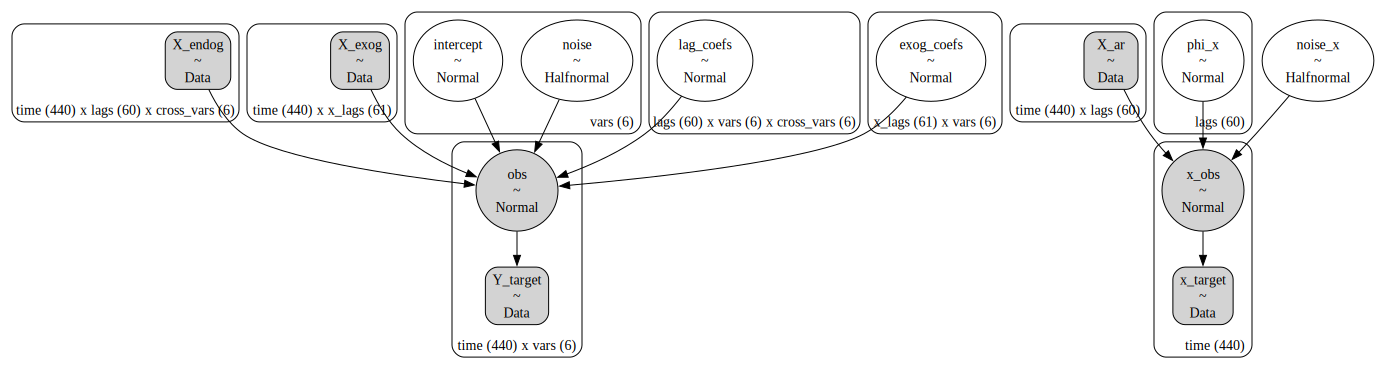

In [8]:
pm.model_to_graphviz(BVARX_model)

In [9]:
with BVARX_model:
    trace = pm.sample(
        draws=1000,
        tune=1000,
        chains=10,
        cores=1,                 # sequential chains, stable in Jupyter
        target_accept=0.95,
        init="adapt_diag",
    )

Initializing NUTS using adapt_diag...
Sequential sampling (10 chains in 1 job)
NUTS: [intercept, noise, lag_coefs, exog_coefs, phi_x, noise_x]


Output()

Sampling 10 chains for 1_000 tune and 1_000 draw iterations (10_000 + 10_000 draws total) took 3493 seconds.


array([[<Axes: title={'center': 'noise'}>,
        <Axes: title={'center': 'noise'}>],
       [<Axes: title={'center': 'noise_x'}>,
        <Axes: title={'center': 'noise_x'}>],
       [<Axes: title={'center': 'phi_x'}>,
        <Axes: title={'center': 'phi_x'}>],
       [<Axes: title={'center': 'exog_coefs'}>,
        <Axes: title={'center': 'exog_coefs'}>]], dtype=object)

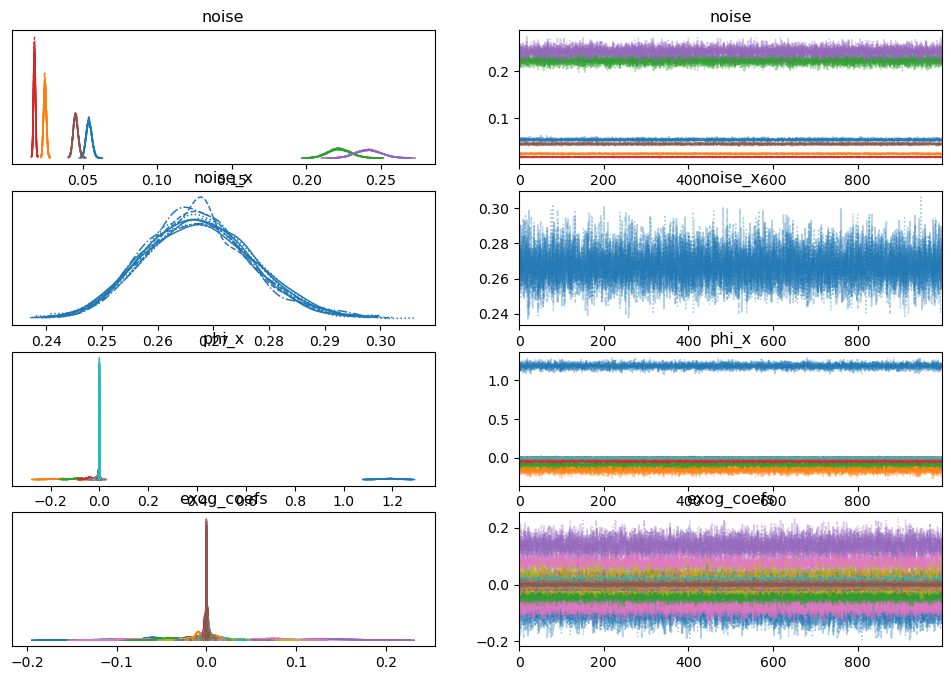

In [10]:
az.plot_trace(trace, var_names=["noise", "noise_x", "phi_x", "exog_coefs"])

In [11]:
post = trace.posterior.stack(sample=("chain","draw"))
A = post["lag_coefs"].values   # (lags, vars, cross_vars, sample)
A = np.moveaxis(A, -1, 0)      # (sample, lags, K, K)

rng = np.random.default_rng(123)
idx = rng.choice(A.shape[0], size=min(200, A.shape[0]), replace=False)

max_mods = []
for i in idx:
    eigs = companion_eigs(A[i])
    max_mods.append(np.max(np.abs(eigs)))

np.mean(np.array(max_mods) < 1), np.quantile(max_mods, [0.5, 0.9, 0.99])

(np.float64(0.635), array([0.99926642, 1.00379417, 1.01398641]))

In [12]:
# -------------------------------
# IRFs: shock is an innovation to exog def_gdp (in original pp units)
# -------------------------------
H = 60

shock_pp = 1.0 /10
shock_std = shock_pp / data[exog_name].std()   # convert to standardized units

post = trace.posterior.stack(sample=("chain", "draw"))

A = post["lag_coefs"].values      # (lags, K, K, sample)
A = np.moveaxis(A, -1, 0)         # (sample, lags, K, K)

B = post["exog_coefs"].values     # (x_lags, K, sample)
B = np.moveaxis(B, -1, 0)         # (sample, x_lags, K)  where x_lags = lags+1

phi = post["phi_x"].values        # (lags, sample)
phi = np.moveaxis(phi, -1, 0)     # (sample, lags)

# optional: filter stable draws using A
max_mods = np.array([np.max(np.abs(companion_eigs(A[i]))) for i in range(A.shape[0])])
stable_idx = np.where(max_mods < 1)[0]

rng = np.random.default_rng(123)
use_pool = stable_idx if stable_idx.size > 0 else np.arange(A.shape[0])
use = rng.choice(use_pool, size=min(10000, use_pool.size), replace=False)

irfs_std = []
xpaths_std = []

for i in use:
    x_path = ar_impulse_path(phi[i], H, shock0=shock_std)   # x in std units
    y_path = varx_irf(A[i], B[i], x_path, H)                # y in std units
    xpaths_std.append(x_path)
    irfs_std.append(y_path)

irfs_std = np.stack(irfs_std, axis=0)        # (draw, H+1, K)
xpaths_std = np.stack(xpaths_std, axis=0)    # (draw, H+1)

# unstandardize endogenous responses
stds_endog = data[vars_endog].std().to_numpy()
irfs = irfs_std * stds_endog[None, None, :]

# Convert log responses to percent (approx)
log_vars = {"log_rgov_pc", "log_rgdp_pc", "log_tfp"}
irfs_plot = irfs.copy()
for j, name in enumerate(vars_endog):
    if name in log_vars:
        irfs_plot[:, :, j] = 100.0 * irfs[:, :, j]

# sanity check: exog path impact should be +1pp (in original units)
x_impact_pp = np.median(xpaths_std[:, 0]) * data[exog_name].std()
print("Median impact in def_delta (pp):", x_impact_pp, " target:", shock_pp)

Median impact in def_delta (pp): 0.1  target: 0.1


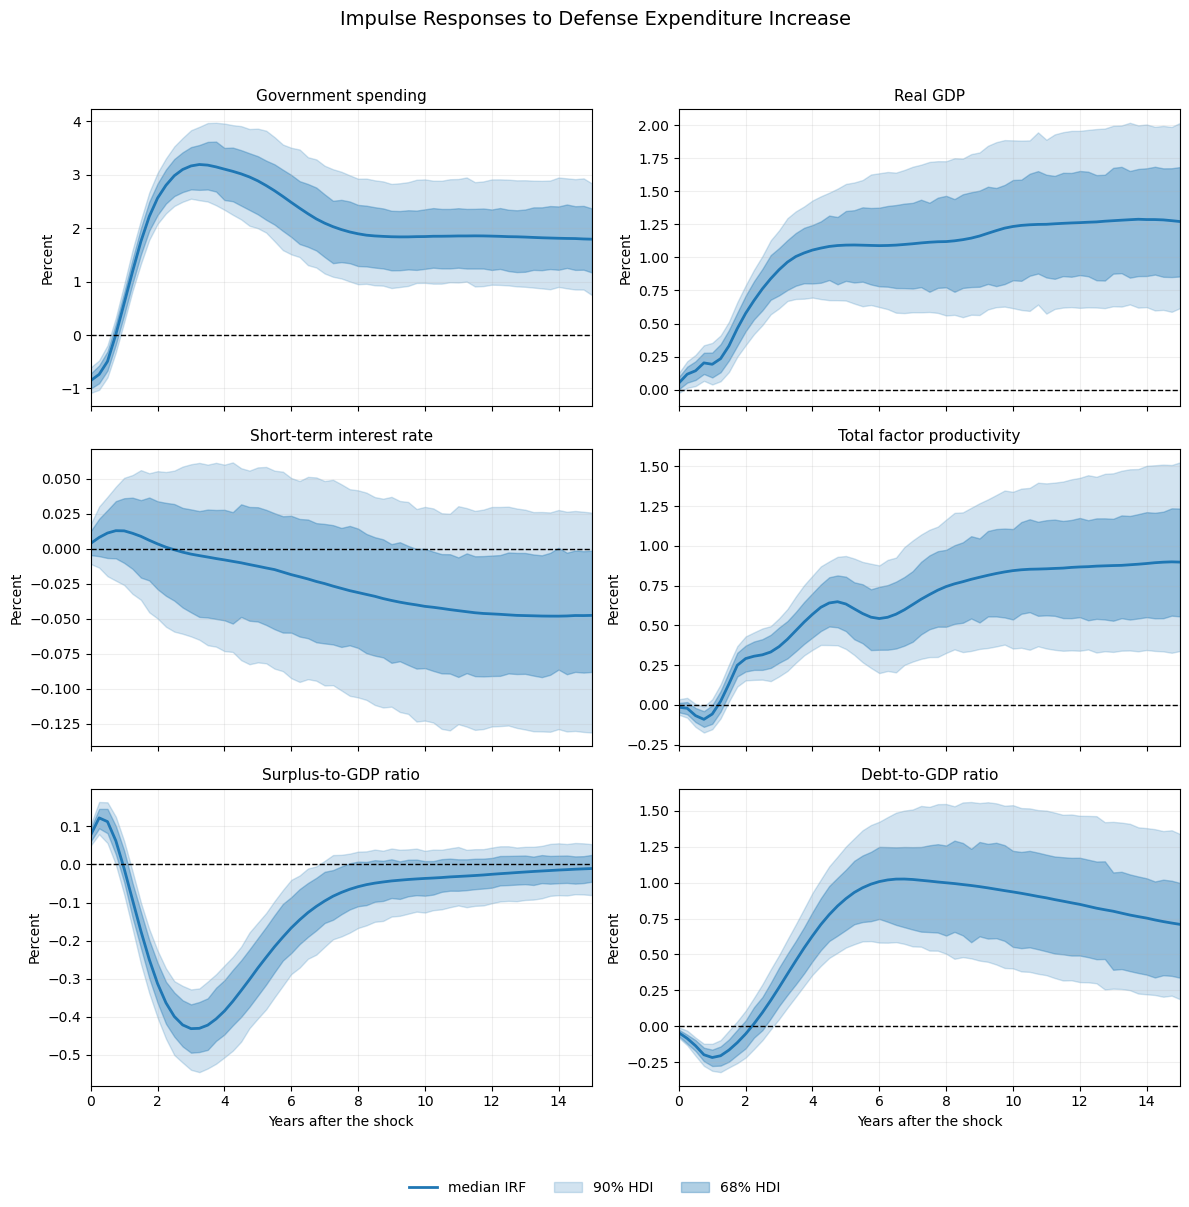

In [14]:
horiz_years = np.arange(H + 1) / 4

# --- layout ---
nrows, ncols = 3, 2
fig, axes = plt.subplots(nrows, ncols, figsize=(12, 12), sharex=True)
axes = axes.ravel()

xmax = 15
xticks = np.arange(0, xmax + 1, 2)

pretty = {
    "log_rgov_pc": "Government spending",
    "log_rgdp_pc": "Real GDP",
    "tbill": "Short-term interest rate",
    "log_tfp": "Total factor productivity",
    "def_gdp": "Surplus-to-GDP ratio",
    "debt_gdp": "Debt-to-GDP ratio",
}

names = vars_endog
for ax, name in zip(axes, names):
    j = vars_endog.index(name)  # robust index into irfs_plot

    y = irfs_plot[:, :, j]                 # (draw, horizon)
    med = np.median(y, axis=0)

    arr = xr.DataArray(y, dims=("draw", "horizon")).expand_dims(chain=[0])
    hdi68 = az.hdi(arr, hdi_prob=0.68).to_array().squeeze()
    hdi90 = az.hdi(arr, hdi_prob=0.90).to_array().squeeze()

    lo68 = hdi68.sel(hdi="lower").values
    hi68 = hdi68.sel(hdi="higher").values
    lo90 = hdi90.sel(hdi="lower").values
    hi90 = hdi90.sel(hdi="higher").values

    ax.plot(horiz_years, med, linewidth=2, color="C0", label="median IRF")
    ax.fill_between(horiz_years, lo90, hi90, alpha=0.20, color="C0", label="90% HDI")
    ax.fill_between(horiz_years, lo68, hi68, alpha=0.35, color="C0", label="68% HDI")

    ax.axhline(0, lw=1, ls="--", color="black")  # dashed zero line
    ax.set_xlim(0, xmax)
    ax.set_xticks(xticks)

    ax.set_title(pretty.get(name, name), fontsize=11)
    ax.set_ylabel("Percent")
    ax.grid(alpha=0.2)

# turn off any unused axes (if < 6 plots)
for k in range(len(names), len(axes)):
    axes[k].axis("off")

# x-label only on bottom row
for ax in axes[-ncols:]:
    ax.set_xlabel("Years after the shock")

# one shared legend (avoid repeating)
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="lower center", ncol=3, frameon=False)

fig.suptitle("Impulse Responses to Defense Expenditure Increase", y=0.995, fontsize=14)
fig.tight_layout(rect=[0, 0.05, 1, 0.97])
plt.savefig(Path.cwd().parent / "figures" / "ADS_extended_bvarx.png")